### Download Template

In [ ]:
!wget https://gist.githubusercontent.com/b1nch3f/b702d2ebfd2c751aa21b68c7425e0d4e/raw/c77225291924a8d2c33c210d74f2744210b6b716/d2l.py -O d2l.py

--2022-07-23 23:40:00--  https://gist.githubusercontent.com/b1nch3f/b702d2ebfd2c751aa21b68c7425e0d4e/raw/c77225291924a8d2c33c210d74f2744210b6b716/d2l.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59707 (58K) [text/plain]
Saving to: ‘d2l.py’

d2l.py              100%[===================>]  58.31K  --.-KB/s    in 0.001s  

2022-07-23 23:40:00 (64.1 MB/s) - ‘d2l.py’ saved [59707/59707]



<img src="https://classic.d2l.ai/_images/attention-output.svg" />

Mathematically, suppose that we have a query $\mathbf{q} \in \mathbb{R}^q$ and $m$ key-value pairs $(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)$, where any $\mathbf{k}_i \in \mathbb{R}^k$ and any $\mathbf{v}_i \in \mathbb{R}^v$. The attention pooling $f$ is instantiated as a weighted sum of the values:

$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v$

where the attention weight (scalar) for the query $q$ and key $k_i$ is computed by the softmax operation of an attention scoring function  that maps two vectors to a scalar:

$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}$

### Masked Softmax Operation

In [ ]:
import tensorflow as tf
import d2l

In [ ]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return tf.nn.softmax(X, axis=-1)
    else:
        shape = X.shape
        if len(valid_lens.shape) == 1:
            valid_lens = tf.repeat(valid_lens, repeats=shape[1])

        else:
            valid_lens = tf.reshape(valid_lens, shape=-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = d2l.sequence_mask(tf.reshape(X, shape=(-1, shape[-1])), valid_lens, value=-1e6)
        return tf.nn.softmax(tf.reshape(X, shape=shape), axis=-1)

In [ ]:
masked_softmax(tf.random.uniform(shape=(2, 2, 4)), tf.constant([2, 3]))

<tf.Tensor: shape=(2, 2, 4), dtype=float32, numpy=
array([[[0.46238595, 0.53761405, 0.        , 0.        ],
        [0.35174498, 0.64825505, 0.        , 0.        ]],

       [[0.3580577 , 0.22018239, 0.42175987, 0.        ],
        [0.29971448, 0.37820384, 0.32208169, 0.        ]]], dtype=float32)>

In [ ]:
masked_softmax(tf.random.uniform((2, 2, 4)), tf.constant([[1, 3], [2, 4]]))

<tf.Tensor: shape=(2, 2, 4), dtype=float32, numpy=
array([[[1.        , 0.        , 0.        , 0.        ],
        [0.2606538 , 0.37416744, 0.3651788 , 0.        ]],

       [[0.44097537, 0.55902463, 0.        , 0.        ],
        [0.26512516, 0.13294078, 0.33062238, 0.27131167]]], dtype=float32)>

### Additive Attention

Given a query $\mathbf{q} \in \mathbb{R}^q$ and a key $\mathbf{k} \in \mathbb{R}^k$, the additive attention scoring function

$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R}$

where learnable parameters $\mathbf W_q\in\mathbb R^{h\times q}$, $\mathbf W_k\in\mathbb R^{h\times k}$, and $\mathbf w_v\in\mathbb R^{h}$.

In [ ]:
class AdditiveAttention(tf.keras.layers.Layer):
    """Additive attention."""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super().__init__(**kwargs)
        self.W_k = tf.keras.layers.Dense(num_hiddens, use_bias=False)
        self.W_q = tf.keras.layers.Dense(num_hiddens, use_bias=False)
        self.w_v = tf.keras.layers.Dense(1, use_bias=False)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, queries, keys, values, valid_lens, **kwargs):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of `queries`: (`batch_size`, no. of
        # queries, 1, `num_hiddens`) and shape of `keys`: (`batch_size`, 1,
        # no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        features = tf.expand_dims(queries, axis=2) + tf.expand_dims(
            keys, axis=1)
        features = tf.nn.tanh(features)
        # There is only one output of `self.w_v`, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores`:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = tf.squeeze(self.w_v(features), axis=-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of `values`: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return tf.matmul(self.dropout(
            self.attention_weights, **kwargs), values)

In [ ]:
queries, keys = tf.random.normal(shape=(2, 1, 20)), tf.ones((2, 10, 2))
# The two value matrices in the `values` minibatch are identical
values = tf.repeat(tf.reshape(
    tf.range(40, dtype=tf.float32), shape=(1, 10, 4)), repeats=2, axis=0)
valid_lens = tf.constant([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention(queries, keys, values, valid_lens, training=False)

<tf.Tensor: shape=(2, 1, 4), dtype=float32, numpy=
array([[[ 2.      ,  3.      ,  4.      ,  5.      ]],

       [[10.      , 11.      , 12.000001, 13.      ]]], dtype=float32)>

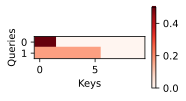

In [ ]:
d2l.show_heatmaps(tf.reshape(attention.attention_weights, (1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

### Scaled Dot-Product Attention

$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}$

The scaled dot-product attention of queries $\mathbf Q\in\mathbb R^{n\times d}$, keys $\mathbf K\in\mathbb R^{m\times d}$, and values $\mathbf V\in\mathbb R^{m\times v}$ is

$\mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}$

In [ ]:
class DotProductAttention(tf.keras.layers.Layer):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = tf.keras.layers.Dropout(dropout)

    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    def call(self, queries, keys, values, valid_lens, **kwargs):
        d = queries.shape[-1]
        scores = tf.matmul(queries, keys, transpose_b=True)/tf.math.sqrt(
            tf.cast(d, dtype=tf.float32))
        self.attention_weights = masked_softmax(scores, valid_lens)
        return tf.matmul(self.dropout(self.attention_weights, **kwargs), values)

In [ ]:
queries = tf.random.normal(shape=(2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention(queries, keys, values, valid_lens, training=False)

<tf.Tensor: shape=(2, 1, 4), dtype=float32, numpy=
array([[[ 2.      ,  3.      ,  4.      ,  5.      ]],

       [[10.      , 11.      , 12.000001, 13.      ]]], dtype=float32)>

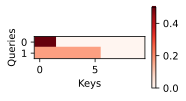

In [ ]:
d2l.show_heatmaps(tf.reshape(attention.attention_weights, (1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')